In [1]:
import os, cv2
import numpy as np
import cv2
import matplotlib.pyplot as plt

# get groudtruth

In [112]:
f = open('/home/imsn-s/open/basic-yolo/gt.txt', 'r')
gtbox=np.zeros((526,30,5))
boxnum=np.zeros(526)
for line in f.readlines():
    temp=line.strip().split(',')
    flash=int(temp[0])
    bn=int(boxnum[flash])+1
    if (int(temp[6])==1. and temp[8]>0.5):
        gtbox[flash,bn,0]=int(temp[2])+int(temp[4])/2
        gtbox[flash,bn,1]=int(temp[3])+int(temp[5])/2
        gtbox[flash,bn,2]=int(temp[4])
        gtbox[flash,bn,3]=int(temp[5])
        gtbox[flash,bn,4]=temp[8]
        boxnum[flash]+=1
f.close()
f = open('/home/imsn-s/open/basic-yolo/gt2.txt', 'w')
for i in range (1,526):
    for j in range(1,int(boxnum[i])+1):
        f.write('%d'%i+' '+'%d'%j+' ''%d'%(gtbox[i,j,0])+' '+'%d'%(gtbox[i,j,1])+' '+'%d'%(gtbox[i,j,2])+' '+'%d'%(gtbox[i,j,3])+' '+'%f'%(gtbox[i,j,4])+'\n')
f.close()

# get yolo rfbox

In [31]:
f = open('/home/imsn-s/open/basic-yolo/MOT17_09.txt', 'r')
rfbox=np.zeros((525,30,5))
for line in f.readlines():
    temp=line.strip().split(' ')
    flash=int(temp[0])
    bn=int(temp[1])
    rfbox[flash,bn,0]=(temp[2])
    rfbox[flash,bn,1]=(temp[3])
    rfbox[flash,bn,2]=(temp[4])
    rfbox[flash,bn,3]=(temp[5])
    rfbox[flash,bn,4]=(temp[6])

In [32]:
def IOU(rf,gt):
    endx=max(rf[0]+rf[2]/2,gt[0]+gt[2]/2)
    startx=min(rf[0]-rf[2]/2,gt[0]-gt[2]/2)
    width=rf[2]+gt[2]-(endx-startx)
    endy=max(rf[1]+rf[3]/2,gt[1]+gt[3]/2)
    starty=min(rf[1]-rf[3]/2,gt[1]-gt[3]/2)
    height=rf[3]+gt[3]-(endy-starty)
    if width <=0 or height<=0:
        ratio=0
    else:
        area = width * height
        area1= rf[2]*rf[3]
        area2= gt[2]*gt[3]
        ratio = area*1./(area1+area2-area)
    return ratio

In [84]:

def draw_boxes(image, boxes,color):
    
    for box in boxes:
        xmin  = int((box[0] - box[2]/2) )
        xmax  = int((box[0] + box[2]/2) )
        ymin  = int((box[1] - box[3]/2) )
        ymax  = int((box[1] + box[3]/2) )
        if(box[4]>0.5):
            cv2.rectangle(image, (xmin,ymin), (xmax,ymax), color, 3)
        """
        cv2.putText(image, 
                    str(box[4]), 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * image.shape[0], 
                    (0,255,0), 2)
        """
    return image

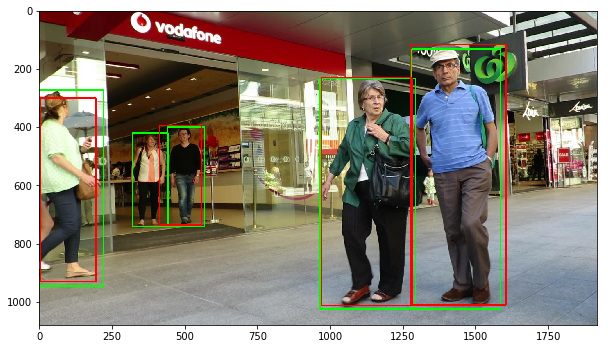

In [95]:
plt.figure(figsize=(10,10))
image = cv2.imread('/home/imsn-s/open/MOT_Images/MOT17_09_img/000143.jpg')
image = draw_boxes(image,gtbox[143,:,:],(0,255,0))
image = draw_boxes(image,rfbox[143,:,:],(0,0,255))
plt.imshow(image[:,:,::-1]); plt.show()

In [121]:
yoloiou=np.zeros(525)
for i in range(1,525):
    rfnum=0
    gtnum=int(boxnum[i])+1
    for j in range(1,30):
        if rfbox[i,j,0] ==0:
            rfnum=j
            break
    iouvalue =0
    for j in range(1,gtnum):
        ioutemp=np.zeros(rfnum)
        if gtbox[i,j,4]>0.5:
            for k in range(1,rfnum):
                ioutemp[k]=IOU(rfbox[i,k,:],gtbox[i,j,:])               
        iou=max(ioutemp)
        if iou > 0.3 :
            iouvalue +=iou
    sumnum=0
    for k in range(1,gtnum):
        if gtbox[i,k,4]>0.5:
            sumnum+=1
    yoloiou[i-1]=iouvalue/sumnum      

# mask RCNN results 

In [90]:
def as_num(x):
    y='{:.1f}'.format(float(x))
    return float(y)
def isperson(str):
    if str[:6]=='person':
        return True
    else :
        return False
    
rfbox2=np.zeros((525,30,5))
maskboxnum=np.zeros(525)
for i in range(1,525):
    if i<10:
        f = open('/home/imsn-s/open/MOT_Images/detectron_out/MOT17_09_img/00000'+str(i),'r')
    elif i<100:
        f = open('/home/imsn-s/open/MOT_Images/detectron_out/MOT17_09_img/0000'+str(i),'r')
    else:
        f = open('/home/imsn-s/open/MOT_Images/detectron_out/MOT17_09_img/000'+str(i),'r')
    txt=f.read()
    temp=txt.strip().split()
    boxnum2=int(maskboxnum[i])+1
    for it,c in enumerate(temp):
        if c=='[' and isperson(temp[it-1]) :
            x=(as_num(temp[it+3])+as_num(temp[it+1]))/2.
            y=(as_num(temp[it+4])+as_num(temp[it+2]))/2.
            w=(as_num(temp[it+3])-as_num(temp[it+1]))
            h=(as_num(temp[it+4])-as_num(temp[it+2]))
            rfbox2[i,boxnum2,0]=x
            rfbox2[i,boxnum2,1]=y
            rfbox2[i,boxnum2,2]=w
            rfbox2[i,boxnum2,3]=h
            rfbox2[i,boxnum2,4]=1
            boxnum2+=1
    maskboxnum[i]=boxnum2

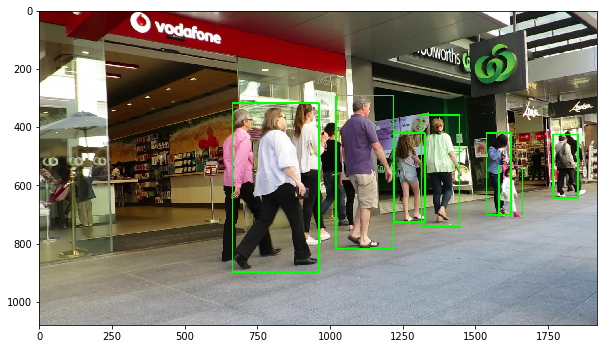

In [113]:
plt.figure(figsize=(10,10))
image = cv2.imread('/home/imsn-s/open/MOT_Images/MOT17_09_img/000248.jpg')
image = draw_boxes(image,gtbox[248,:,:],(0,255,0))
#image = draw_boxes(image,rfbox2[248,:,:],(0,0,255))
plt.imshow(image[:,:,::-1]); plt.show()

In [122]:
maskrcnniou=np.zeros(525)
for i in range(1,525):
    rfnum=int(maskboxnum[i])
    gtnum=int(boxnum[i])+1
    iouvalue =0
    for j in range(1,gtnum):
        ioutemp=np.zeros(rfnum)
        if gtbox[i,j,4]>0.5:
            for k in range(1,rfnum):
                ioutemp[k]=IOU(rfbox2[i,k,:],gtbox[i,j,:])               
        iou=max(ioutemp)
        if iou > 0.3 :
            iouvalue +=iou
    sumnum=0
    for k in range(1,gtnum):
        if gtbox[i,k,4]>0.5:
            sumnum+=1
    maskrcnniou[i-1]=iouvalue/sumnum

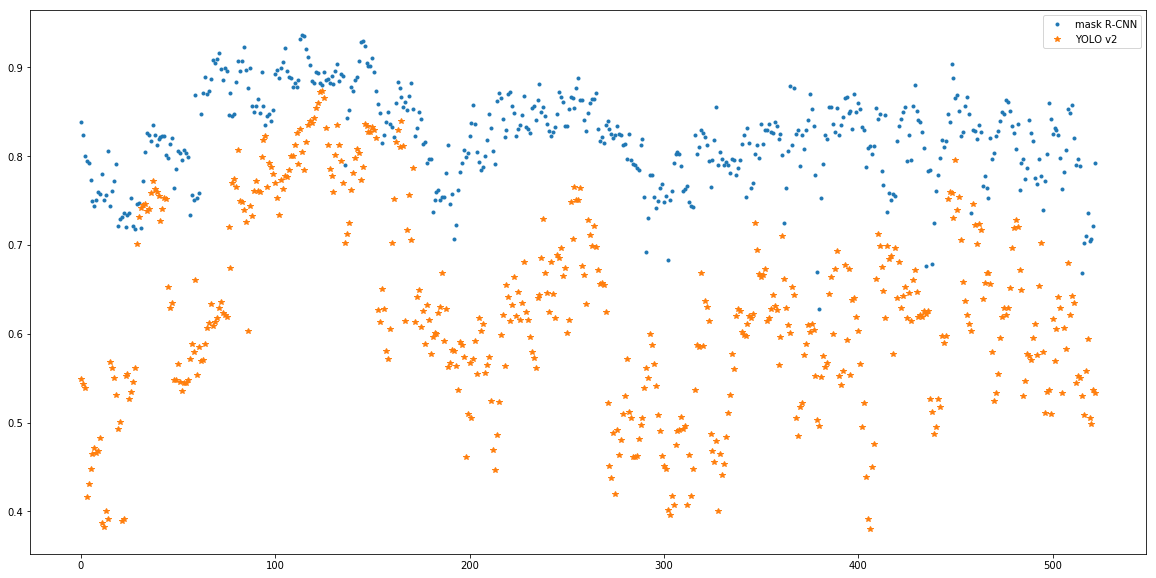

In [132]:
plt.figure(figsize=(20,10))
plt.plot(maskrcnniou[1:524],'.',label='mask R-CNN')
plt.plot(yoloiou[1:524],'*',label='YOLO v2')
plt.legend()

In [134]:
maskmean=np.mean(maskrcnniou[1:525])
yolomean=np.mean(yoloiou[1:525])

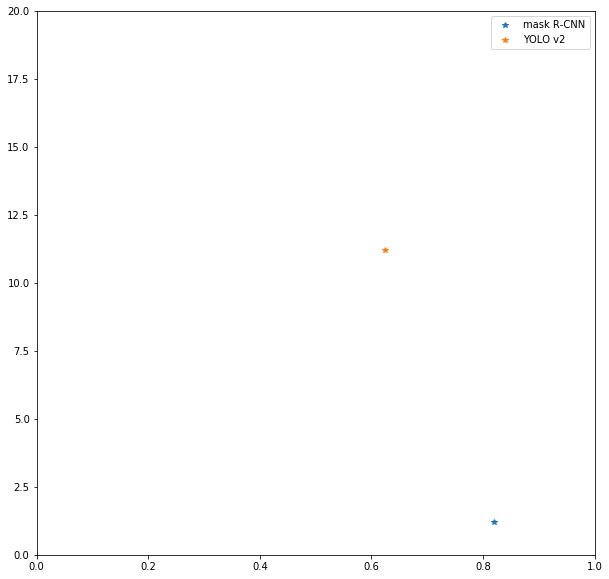

In [139]:
from pylab import *
plt.figure(figsize=(10,10))
xlim([0,1])
ylim([0,20])
plt.plot([maskmean],[1.2],'*',label='mask R-CNN')
plt.plot([yolomean],[11.2],'*',label='YOLO v2')
plt.legend()

In [140]:
print(maskmean,yolomean)

(0.8196809455673517, 0.6239672559479753)
